# Installing packages and downloading pretrained model

In [1]:
#!pip install transformers
#!pip install datasets

In [7]:
#import google
from pprint import pprint

import numpy as np
import torch
from transformers import AutoModel, AutoTokenizer, BertTokenizer
#from datasets import list_datasets, list_metrics, load_dataset, load_metric

torch.set_grad_enabled(False)

import itertools
import numpy as np
import pandas as pd
from scipy import stats 
from scipy import corrcoef
from scipy.spatial.distance import cosine, euclidean, pdist, squareform, is_valid_dm, cdist
from sklearn.metrics import pairwise_distances
from scipy.stats import spearmanr
from scipy.spatial import distance_matrix
import torch

#Visualization packages
import seaborn as sns
import matplotlib.pylab as plt

In [3]:
# Store the model we want to use
#MODEL_NAME = "bert-base-uncased" #@param
MODEL_NAME = "gpt2" # doesn't quite work?

# We need to create the model and tokenizer
model = AutoModel.from_pretrained(MODEL_NAME,
                                  output_hidden_states=True,
                                  output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME 
                                          )

# Accessing the hidden states (contextualized embeddings)

In [4]:
def combine_output_for_layers(model, inputs, states, word_groups, layers):
    # Stack all words in the sentence
    if MODEL_NAME in ["gpt2", "gpt2-medium", "gpt2-large"]:
        emb_layer = model.wte
    else:
        emb_layer = model.embeddings.word_embeddings
        
    sent_tokens_output = torch.stack([
        # Sum the requested layers
        torch.stack([
                states[i].detach()[:,token_ids_word].mean(axis=1)
                    if i > 0 else
                emb_layer(inputs)[:,token_ids_word].mean(axis=1)
                        for i in layers
            ]).sum(axis=0).squeeze()
                for token_ids_word in word_groups
        ])
#    print("OUTPUT SHAPE", sent_tokens_output.shape)
    return sent_tokens_output

# Retrieving word representations from separate or combined layers

In [5]:
sentences = [
        "Do not compare apples and oranges and apples and apples and apples and apples.",
        "another sentence.",
        "space before .",
    ]

In [11]:
from collections import defaultdict
vecs = []
layer_result = defaultdict(list)
sent_words = []

for sent in sentences:
    encoded = tokenizer(sent, return_tensors="pt")
    inputs = encoded.input_ids
    attention_mask =  encoded['attention_mask']
    output = model(input_ids=inputs, attention_mask=attention_mask)
    states = output.hidden_states
    token_len = attention_mask.sum().item()
    decoded = tokenizer.convert_ids_to_tokens(inputs[0], skip_special_tokens=False)
    if MODEL_NAME in ["gpt2", "gpt2-medium", "gpt2-large"]:
        word_indices = np.array(list(map(lambda e: -1 if e is None else e, encoded.word_ids())))[:token_len]
        word_groups = np.split(np.arange(word_indices.shape[0]), np.unique(word_indices, return_index=True)[1])[1:]
        sw = ["".join(list(map(lambda t: t[1:] if t[:1] == "Ġ" else t, np.array(decoded)[g]))) for g in word_groups]
        sent_words.append(sw)
    else:
        word_indices = np.array(list(map(lambda e: -1 if e is None else e, encoded.word_ids())))[1:token_len - 1]
        word_groups = np.split(np.arange(word_indices.shape[0]) + 1, np.unique(word_indices, return_index=True)[1])[1:]
        sent_words.append(["".join(list(map(lambda t: t[2:] if t[:2] == "##" else t, np.array(decoded)[g]))) for g in word_groups])

    for n, layer_group in enumerate([[1], [4], [8], [12], [9,10,11,12], [0]]):
        sent_vec = combine_output_for_layers(model, inputs, states, word_groups, layer_group)
        layer_result[n].append(sent_vec)

vecs = [np.concatenate(r) for r in layer_result.values()]


# Compute and visualize dissimilarity matrices

In [8]:
distance_matrices = [
    cdist(vec, vec, "euclidean").round(1)
        for vec in vecs
]

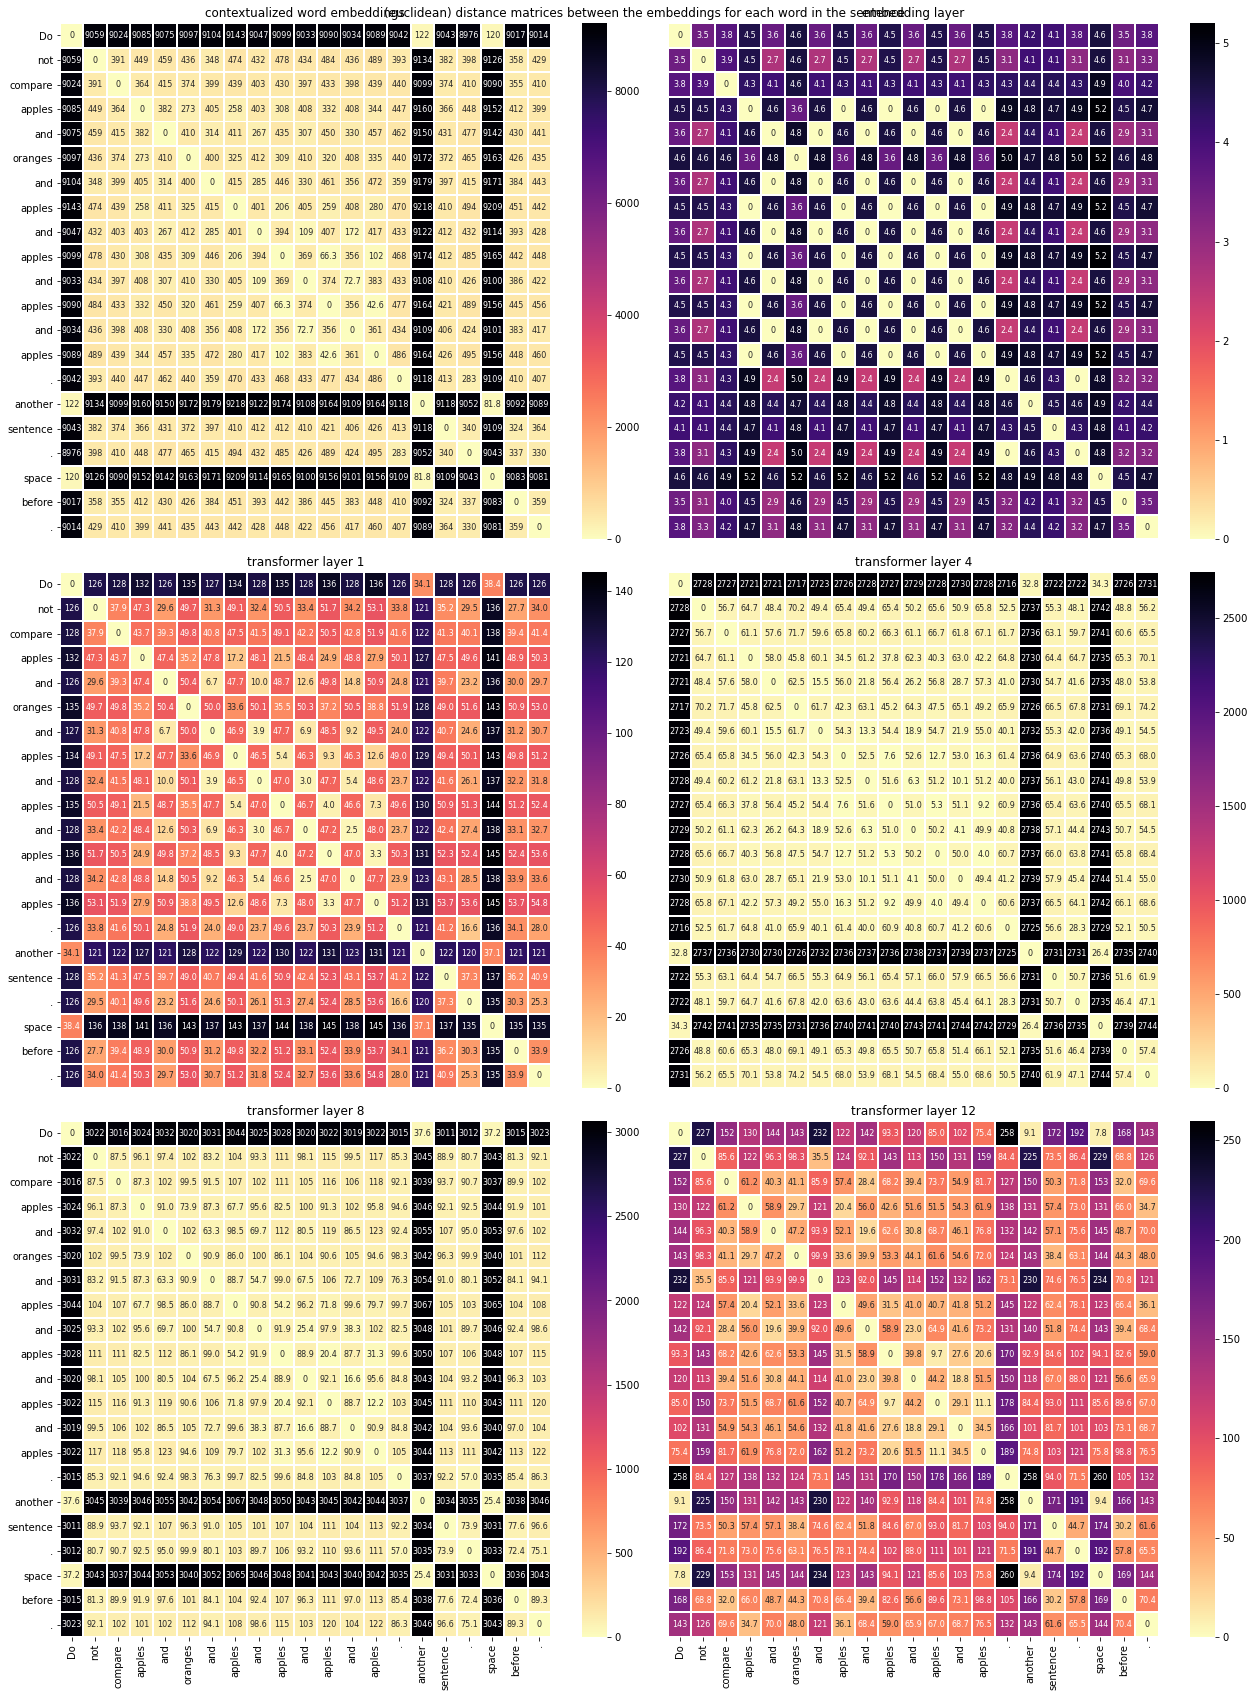

In [85]:
labels = list(itertools.chain.from_iterable(sent_words))

plot_data = [
    ("y",  4, "contextualized word embeddings"),
    ("",   5, "embedding layer"),
    ("y",  0, "transformer layer 1"),
    ("",   1, "transformer layer 4"),
    ("xy", 2, "transformer layer 8"),
    ("x",  3, "transformer layer 12"),
]


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 24))
fig.suptitle('(euclidean) distance matrices between the embeddings for each word in the sentence')

for subplot, (label_axes, matrix_index, title) in zip(itertools.chain.from_iterable(axes), plot_data):
    heatmap_args = dict(
        linewidth=1, 
        annot = np.array([[f"{v:.0f}" if (v == 0 or len(str(v)) > 4) else f"{v:.1f}" for v in r] for r in distance_matrices[matrix_index]]),
        annot_kws={"size":8}, 
        fmt="",
        cmap = 'magma_r', 
        xticklabels=labels, 
        yticklabels=labels,
    )

    heatmap = sns.heatmap(distance_matrices[matrix_index], ax=subplot, **heatmap_args)
    subplot.set_title(title)
    for axis in [x for x in "xy" if x not in label_axes]:
        getattr(subplot, f"{axis}axis").set_visible(False)
fig.tight_layout()
plt.show()


The visualization nicely shows that the 'apples' in the example sentence receive very similar embeddings in layer 1, which are very different from 'oranges' (in fact, the embeddings for 'apples' are of course identical in the input embeddings). And then the 'apples' at the end behaves differently when we move higher up in the BERT layer, and the difference between the other apples and the oranges become smaller.

Using these DMs, it should be rather straightforward to run the Mantel test, and hopefully also to run this on a larger set of input sentences.